Summary: Implement Inverse Distance Weighting (IDW) on two test functions: 
- sine function $$y=\sin x$$
- and Runge function $$y = \frac{1}{1+25x^2}$$

and add confidence bounds. 

## Prep

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import dates
import os
from matplotlib.ticker import FuncFormatter, MultipleLocator

import seaborn as sns
import scipy.stats as stats

## set up Latex rendering (see latex_rendering.ipynb for more info)
import latex_support as latex
plt.style.use('tex')
plt.style.use('seaborn-colorblind')

## Test functions

We define the sine and Runge function. 

In [3]:
def test_function(x, function='runge'): 
    if function=='runge': 
        return runge(x)
    elif function=='sine': 
        return sine(x)
    elif function=='quadratic':
        return quadratic(x)
    else:
        print('Error: Please choose a valid test function. ')
        

def sine(x): 
    """
    calculate y = sin x
    input: x
    ouput: y
    """
    return np.sin(x)

def runge(x): 
    """
    calculate Runge function y = 1 / (1 + 25*x**2)
    input: x
    ouput: y
    """
    return 1/(1+25*x**2)

def quadratic(x):
    """
    calculate quadratic function y = x**2
    input: x
    ouput: y
    """
    return x**2

## Base points and interpolated points

We need a function to draw i values from a range. 

In [3]:
def x_draw(x_min, x_max, i): 
    """
    randomly draw i x-values from range (x_min, x_max)
    input: 
    - x_min: lower limit 
    - x_max: upper limit
    - i: number of values drawn
    ouput: array with i random values
    """
    return np.random.uniform(x_min,x_max,i)

## IDW

We implement IDW. The formula for an interpolated y-value is: 
$$ \textrm{ y_idw[i]} = \frac{\sum_j \frac{\textrm{ y_base[i]}}{d_j}}{\sum_j \frac{1}{d_j}}$$

where 

$$ \textrm{d_j} =  (\textrm{ x_base[j]} - \textrm{ x_idw[i]})^2$$

The standard error for each interpolated point is also calculated from

$$ \textrm{ se[i]} = \sqrt{\sum_i d_i}$$

In [4]:
def squared_distance(x_0, x_i):
    """
    calculate the squared distance between two points in 1D
    input: two x-values
    output: squared distance between them
    """
    d = (x_0 - x_i)**2
    return d

def idw(x_base, y_base, x_idw):
    """
    do 1D IDW on a list of x-values and calculate standard error
    input: 
    - x_base: known x-values
    - y_base: known y-values
    - x_idw: x-values to be interpolated
    output: 
    - y_idw: interpolated y-values
    - se: 
    """
    ## create empty list for interpolated y-values
    y = []
    se = []
    
    ## loop through x-values to be interpolated
    for i in range(len(x_idw)): 
        
        ## create empty list for distances
        distances = []
                
        ## loop through known x-values
        for j in range(len(x_base)): 
            d = squared_distance(x_base[j], x_idw[i])
            distances.append(d)

        ## calculate and append interpolated y-value
        sum_lower = sum([1/x for x in distances])
        sum_upper = sum([y_base[i]/x for x in distances])
        y_i = sum_upper / sum_lower
        y.append(y_i)
        
        ## calculate and append standard error
        se_i = 1/(np.sqrt(sum([1/x for x in distances])))
        se.append(se_i)
    return y, se


## Run and plot

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html

https://www.google.com/search?client=firefox-b-d&q=error+bound

https://note.nkmk.me/en/python-function-return-multiple-values/

error:  [0.06726793103606679, 0.997714058240585, 0.7977870792016183, 0.3098315441709891, 1.0684885261080301, 0.37203127383313034, 0.0945796329796435, 0.6162971806206177, 0.3612818212322906, 0.10167859264385187]


C:\Users\awsch\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-+" (-> linestyle='-'). The keyword argument will take precedence.


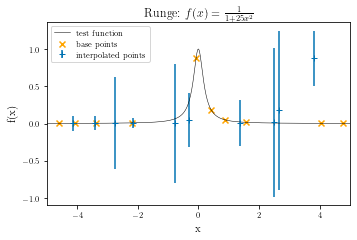

In [19]:
## choose test function
function = 'runge' # Runge function
# function = 'sine' # sine function
# function = 'quadratic' # quadratic function

## configure function plot
x_lower = -5 # lower limit of x-axis
x_upper = 5 # upper limit of x-axis
i_function = 1000 # number of points

## configure number of base points drawn
i_base = 10

## configure number of points to interpolate
i_idw = 10

## configure confidence interval
ci = .90 # other option: 0.95

## configure plot
base=0.5*np.pi # distance between ticks (only for sine plot)

## choose base points (optionally from saved data)
# x_base = x_draw(x_lower, x_upper, i_base) # use this to create new points
# x_base = x_base_sine # use this to load old sine data
x_base = x_base_runge # use this to load old Runge data


## choose interpolated points (optionally from saved data)
x_idw = x_draw(x_lower, x_upper, i_idw) # use this to create new points
# x_idw = x_idw_sine # use this to load old sine data
# x_idw = x_idw_runge # use this to load old Runge data


###################

## calculate function
x = np.linspace(x_lower, x_upper, i_function)
y = test_function(x, function)

## calculate y-values of base points
y_base = test_function(x_base, function)

## do IDW
results_idw = idw(x_base, y_base, x_idw)
y_idw = results_idw[0]
y_idw_se = results_idw[1]

## calculate error bound from standard error
if ci == 0.9: 
    y_idw_err = [1.645*x for x in y_idw_se]
elif ci == 0.95: 
    y_idw_err = [1.96*x for x in y_idw_se]
else: 
    print('Error: Please choose a valid confidence interval!')
print('error: ',y_idw_err)

## create plot
fig, ax = plt.subplots(1, 1, figsize=latex.set_size())

## plot test function
ax.plot(x, y, color='black', linewidth=0.5, label='test function')

## plot base points
ax.scatter(x_base, y_base, marker='x', color='orange',  label='base points')

## plot interpolated points
# ax.scatter(x_idw, y_idw, marker='x',  label='interpolated points')


## plot errorbars
ax.errorbar(x_idw, y_idw, yerr=y_idw_err, fmt='-+', ls='none', 
            label='interpolated points')

## set x-axis ticks for sine plot and change base to change distance between ticks
if function=='sine': 
    ax.xaxis.set_major_formatter(FuncFormatter(
        lambda val,pos: '{:.2g}$\pi$'.format(val/np.pi) if val !=0 else '0'
    ))
    ax.xaxis.set_major_locator(MultipleLocator(base)) 

## set x limits
plt.xlim(x_lower, x_upper)

## set title, labels and legend
if function=='sine': 
    plt.title(r'sine: $f(x) = sin(x)$')
elif function=='runge': 
    plt.title(r'Runge: $f(x) = \frac{1}{1+25x^2}$')
elif function=='quadratic':
    plt.title(r'quadratic: $f(x) = x^2$')
else:
    print('Error: Please choose a valid test function!')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

Save the base points and interpolated points for later. 

In [238]:
x_base_runge = x_base
x_idw_runge = x_idw
%store x_base_runge
%store x_idw_runge


Stored 'x_base_runge' (ndarray)
Stored 'x_idw_runge' (ndarray)


In [8]:
## Load Runge data
%store -r x_base_runge
%store -r x_idw_runge

In [153]:
x_base_sine = x_base
%store x_base_sine

Stored 'x_base_sine' (ndarray)


In [167]:
x_idw_sine = x_idw
%store x_idw_sine

Stored 'x_idw_sine' (ndarray)


To evaluate the IDW, calculate and save the mean squared error. 

In [240]:
## calculate MSE
y_exact = test_function(x_idw)
mse = np.mean(squared_distance(y_idw, y_exact))

In [169]:
## use this for sine
mse_sine = mse
%store mse_sine

Stored 'mse_sine' (float64)


In [7]:
## use this for Runge
mse_runge = mse
%store mse_runge

NameError: name 'mse' is not defined

To retrieve the last MSEs: 

https://www.blopig.com/blog/2020/05/storing-variables-in-jupyter-notebooks-using-store-magic/

In [170]:
%store -r mse_sine
print('MSE for the sine: ', mse_sine)

MSE for the sine:  1.1181956226952048


In [6]:
%store -r mse_runge
print('MSE for Runge: ', mse_runge)

MSE for Runge:  0.4126507776281085


We create a dataframe to store our results. 

In [234]:
df = pd.DataFrame()
df['x_base'] = x_base
df['y_base'] = y_base
df['x_idw'] = x_idw
df['y_idw'] = y_idw
df['y_exact'] = y_exact
df

,x_base,y_base,x_idw,y_idw,y_exact
0,-2.188853,0.008280,-2.976277,0.008280,-0.164564
1,1.582933,0.015713,2.350216,0.015713,0.711322
2,-4.053741,0.002428,-4.417246,0.002428,0.956761
3,-4.586283,0.001898,4.326533,0.001898,-0.926476
4,0.427330,0.179686,1.332188,0.179686,0.971668
5,-0.075087,0.876462,0.609807,0.876462,0.572710
6,-3.362171,0.003526,-3.215250,0.003526,0.073591
7,4.766761,0.001757,4.838277,0.001757,-0.992087
8,0.890445,0.048025,0.244027,0.048025,0.241613
9,4.045787,0.002438,3.444636,0.002438,-0.298427


In [137]:
df.to_latex(index=False)

'\\begin{tabular}{rrrrr}\n\\toprule\n   x\\_base &    y\\_base &     x\\_idw &     y\\_idw &   y\\_exact \\\\\n\\midrule\n 0.054473 &  0.930940 & -0.223149 &  0.930940 & -0.221302 \\\\\n-2.957060 &  0.004554 & -2.880096 &  0.004554 & -0.258526 \\\\\n 1.415815 &  0.019564 &  4.216154 &  0.019564 & -0.879381 \\\\\n-3.517283 &  0.003223 &  0.072038 &  0.003223 &  0.071976 \\\\\n 3.564056 &  0.003139 & -4.735557 &  0.003139 &  0.999732 \\\\\n 2.113209 &  0.008878 & -0.694312 &  0.008878 & -0.639857 \\\\\n-0.628209 &  0.092029 &  2.035824 &  0.092029 &  0.893809 \\\\\n 3.414479 &  0.003419 &  1.481915 &  0.003419 &  0.996053 \\\\\n 0.864414 &  0.050812 & -4.183398 &  0.050812 &  0.863316 \\\\\n 4.804012 &  0.001730 & -3.781464 &  0.001730 &  0.597092 \\\\\n\\bottomrule\n\\end{tabular}\n'

We save the plots and dataframe. 

In [235]:
if sine==True: 
    fig.savefig('theo2a_sine.pdf', bbox_inches='tight')
    df.to_pickle('theo2a_sine_results')
else: 
    fig.savefig('theo2b_runge.pdf', bbox_inches='tight')
    df.to_pickle('theo2b_runge_results')

We calculate the variance of the derivative of the test functions. 

In [4]:
## for sine
x_sample = np.linspace(0, 2*np.pi, 10000)
y_sample = np.cos(x_sample)
np.var(y_sample, ddof=1)

0.5001000000000001

In [5]:
## for Runge
x_sample = np.linspace(0, 2*np.pi, 10000)
y_sample = -50*x_sample/(1+25*x_sample**2)**2
np.var(y_sample, ddof=1)

0.28722354140053064